# PROBLEM DEFINITION
  
- In semiconductor manufacturing, the production of integrated circuits involves multiple complex processes, including wafer fabrication. Wafers are thin, round substrates made of semiconductor materials, and they undergo various manufacturing steps to create microchips. The quality of these wafers is critical for ensuring the reliability and performance of the final IC's.

- The manufacturing process of semiconducter wafers is susceptible to various defects and faults that can compromise the quality and yield of IC's. These faults can result from contamination, equipment malfunctions or process variations. Detecting and classifying these faults early in the manufacturing process is essential to minimze waste and ensure product quality.

## GOAL
- The goal of this experiment notebook is to findout a succesful / generalized predictive classifier model that can accurately classify semiconducter wafers as either "Good" or "Bad" based on sensor data collected during the manufacturing process. 
- According to the domain knowledge of expertizes and regarding business priorities and potential consequences of false predicted cases, the cost function is calculated to be 10.FN + 1.FP 


****

## DATA EXPLORATION

[x]head, info, description

[x]quick profiling reports

[x] missing values analysis

[x]duplicates

[x]outliers

[x]feature distributions

[x]imbalance check

[x]correlation analysis

[x]notes

### NOTES
- all meaningful input features are float64 dtype
- wafer id can be removed
- no duplicated rows
- raw data is highly unscaled
- lots of outliers, even when i set iqr_threshold to 5% and coefficient to 5, there were still lots of outliers
- as an alternative, i peformed multivariate outlier detection using LOF, the elbow method suggested the threshold score to be <-2
- there is no duplicated rows, but are a lot of (more than 100) duplicated columns, may be these are all zero columns.
- there are 112 columns of constant value "0" 
- best_fit_distribution types are found , re-assess after data transformation
- highly imbalanced dataset, handle imbalance with stratified kfold when splitting as train-test dataset
- correlation study is performed with filter condition of abs(corr)>95 or abs(cor)<100 and if the correlated column count > threshold=5  , some columns meeting these conditions are detected

In [1]:
import pandas as pd 
import numpy as np
import os 
import dtale
import seaborn as sns
from scipy import stats 
import warnings
import scipy 

warnings.filterwarnings("ignore")



In [2]:
%%html
<style>
.output_wrapper, .output {
    max-height: 800px; /* Adjust the width as needed */
}
</style>

In [3]:
valid_dataset_dir = "../valid_feature_store/valid_training_data/"


In [4]:
csv_file_list = os.listdir(valid_dataset_dir)
df_merged = pd.DataFrame()
for file in csv_file_list:
    file_path = os.path.join(valid_dataset_dir,file)
    df = pd.read_csv(file_path)
    df_merged = pd.concat(objs=[df_merged,df]) # merged around axis=0

In [5]:
df_merged.head(10)

,Wafer,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,Wafer-501,3076.81,2158.75,2208.2334,1517.0152,1.0980,100.0,110.1900,0.1247,1.4357,...,64.2405,0.5016,0.0152,0.0040,3.0319,0.0465,0.0299,0.0090,64.2405,-1
1,Wafer-502,2951.62,2511.92,2253.5111,1397.5060,0.9660,100.0,109.7611,0.1210,1.5527,...,0.0000,0.4953,0.0105,0.0037,2.1266,-0.0012,0.0252,0.0081,0.0000,-1
2,Wafer-503,2930.42,2505.17,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.4588,...,NaN,0.4958,0.0111,0.0033,2.2296,-0.0012,0.0252,0.0081,0.0000,-1
3,Wafer-504,2997.28,2357.99,2141.0667,1236.5212,0.9698,100.0,98.3344,0.1238,1.5973,...,NaN,0.4962,0.0086,0.0024,1.7297,-0.0012,0.0252,0.0081,0.0000,-1
4,Wafer-505,3025.10,2475.18,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.5525,...,NaN,0.4983,0.0159,0.0041,3.1927,-0.0012,0.0252,0.0081,0.0000,-1
5,Wafer-506,2992.15,2538.05,2162.8445,1312.3198,0.8286,100.0,100.3633,0.1242,1.4509,...,NaN,0.5008,0.0115,0.0035,2.2979,-0.0012,0.0252,0.0081,0.0000,-1
6,Wafer-507,3055.87,2569.67,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.4810,...,NaN,0.4967,0.0110,0.0032,2.2162,-0.0012,0.0252,0.0081,0.0000,-1
7,Wafer-508,2971.23,2626.13,2183.3444,1111.4499,1.5548,100.0,97.5311,0.1236,1.3906,...,NaN,0.5008,0.0154,0.0046,3.0695,-0.0012,0.0252,0.0081,0.0000,-1
8,Wafer-509,NaN,2651.37,2180.7000,1159.3838,1.0177,100.0,98.9367,0.1222,1.5301,...,NaN,0.5058,0.0104,0.0029,2.0538,-0.0012,0.0252,0.0081,0.0000,-1
9,Wafer-510,3028.53,2480.42,2220.4778,1531.6980,1.7751,100.0,107.6856,0.1249,1.5495,...,NaN,0.5011,0.0153,0.0039,3.0578,-0.0012,0.0252,0.0081,0.0000,-1


In [6]:
df_merged.duplicated().any()

False

In [7]:
df_merged.drop(columns=["Wafer"],inplace=True)

In [8]:
df_merged.describe().T 

,count,mean,std,min,25%,50%,75%,max
Sensor-1,1531.0,3015.024193,73.908774,2743.2400,2967.4650,3012.0900,3057.3900,3356.3500
Sensor-2,1530.0,2495.483771,80.495576,2158.7500,2452.1825,2498.8400,2538.5000,2846.4400
Sensor-3,1523.0,2200.370187,29.461460,2060.6600,2180.9666,2200.9889,2217.8667,2315.2667
Sensor-4,1523.0,1400.184797,443.937101,0.0000,1084.3779,1287.3538,1593.1220,3715.0417
Sensor-5,1523.0,4.255665,56.906664,0.6815,1.0177,1.3168,1.5291,1114.5366
...,...,...,...,...,...,...,...,...
Sensor-587,1537.0,0.021432,0.012398,-0.0169,0.0134,0.0207,0.0276,0.1028
Sensor-588,1537.0,0.016414,0.008768,0.0032,0.0106,0.0148,0.0203,0.0799
Sensor-589,1537.0,0.005268,0.002865,0.0010,0.0033,0.0046,0.0064,0.0286
Sensor-590,1537.0,99.777881,94.560344,0.0000,44.2355,71.5753,115.1005,737.3048


In [414]:
d= dtale.show(df_merged)

In [415]:
d.open_browser()

### EDA: Missing Value Analyis

In [416]:
def missing_values_table(dataframe:pd.DataFrame,is_return= False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isna().sum()>0]
    na_data = dataframe[na_cols].isna().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.concat(objs=[na_data,np.round(ratio,2)],axis=1,keys= ["#missing","ratio"])
    print(missing_df,end="\n")
    if is_return:
        return (na_cols,missing_df)
    return missing_df

In [417]:
missing_table = missing_values_table(df_merged)

            #missing  ratio
Sensor-159      1399  91.02
Sensor-158      1399  91.02
Sensor-294      1399  91.02
Sensor-293      1399  91.02
Sensor-493      1311  85.30
...              ...    ...
Sensor-458         1   0.07
Sensor-457         1   0.07
Sensor-456         1   0.07
Sensor-455         1   0.07
Sensor-586         1   0.07

[534 rows x 2 columns]


In [418]:
filtered_missed_table = missing_table.query("ratio>60")

In [419]:
filtered_missed_table

,#missing,ratio
Sensor-159,1399,91.02
Sensor-158,1399,91.02
Sensor-294,1399,91.02
Sensor-293,1399,91.02
Sensor-493,1311,85.30
Sensor-86,1311,85.30
Sensor-359,1311,85.30
Sensor-221,1311,85.30
Sensor-384,988,64.28
Sensor-519,988,64.28


##### ->missing value analysis w/ target variable

In [420]:
def missing_vs_target(dataframe:pd.DataFrame,target:str,na_cols:list):
    i=0
    temp_df = dataframe.copy()
    for col in na_cols:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isna(),1,0)
    
    na_flags= [col for col in temp_df.columns if "_NA_FLAG" in col ]
    

    
    for col in na_flags:
        table= pd.DataFrame({
            "Target_Mean": temp_df.groupby(col)[target].mean(),
            "count":temp_df.groupby(col)[target].count()
        })

        if (abs(table.iloc[1,0])> 0.30) and  (abs(table.iloc[1,0])< 0.70) :
            i+=1
            print(table,end="\n\n")

        
    print(i)

In [421]:
na_cols = missing_values_table(df_merged,is_return=True)[0]

            #missing  ratio
Sensor-159      1399  91.02
Sensor-158      1399  91.02
Sensor-294      1399  91.02
Sensor-293      1399  91.02
Sensor-493      1311  85.30
...              ...    ...
Sensor-458         1   0.07
Sensor-457         1   0.07
Sensor-456         1   0.07
Sensor-455         1   0.07
Sensor-586         1   0.07

[534 rows x 2 columns]


In [345]:
missing_vs_target(df_merged,"Good/Bad",na_cols)

                   Target_Mean  count
Sensor-54_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-55_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-56_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-57_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-58_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-59_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                    Target_Mean  count
Sensor-191_NA_FLAG                    
0   

In [422]:
def missing_row_analysis(dataframe:pd.DataFrame):
    table= pd.DataFrame({
        "#missing":dataframe.isna().sum(axis=1).sort_values(ascending=False),
        "ratio": dataframe.isna().sum(axis=1).sort_values(ascending=False)/ dataframe.shape[0]*100
    })
    return table 

    

In [423]:
missing_row_analysis(df_merged)

,#missing,ratio
36,152,9.889395
34,148,9.629148
31,140,9.108653
22,100,6.506181
81,100,6.506181
...,...,...
22,4,0.260247
26,4,0.260247
43,4,0.260247
87,4,0.260247


### EDA: Outlier Detection

In [424]:
import matplotlib.pyplot as plt 

In [425]:
df_merged.columns 

Index(['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-6',
       'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=591)

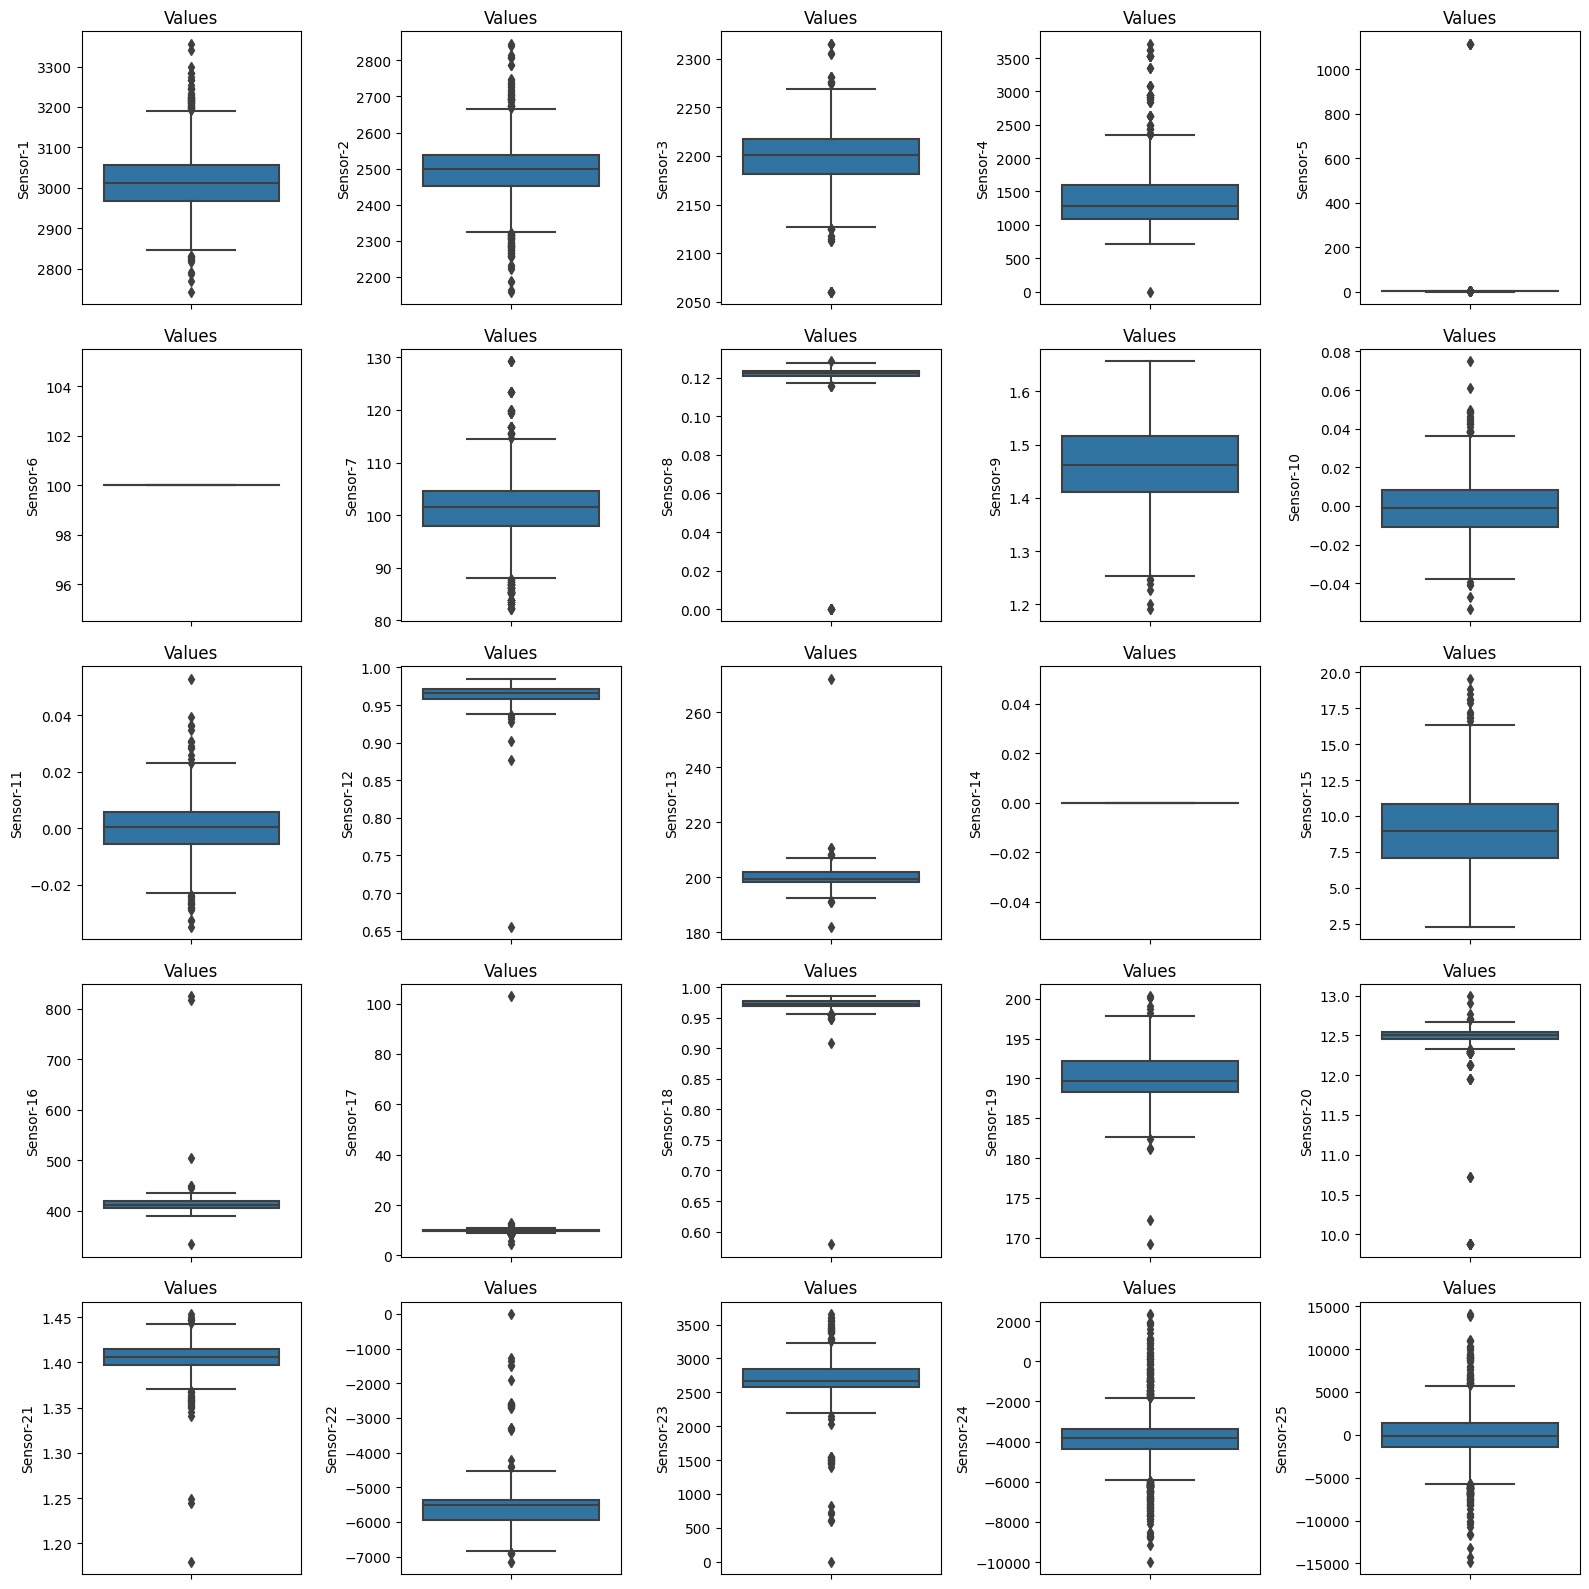

In [426]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
#print(axs)

for i, col in enumerate(df_merged.columns[:25]):
    row = i // 5  
    col_num = i % 5  
    #print(row,col_num)
    sns.boxplot(y=df_merged[col], ax=axs[row, col_num])
    axs[row, col_num].set_title("Values")
    axs[row, col_num].set_ylabel(col)

plt.tight_layout() 
plt.show()


In [427]:
def iqr_threshold(dataframe:pd.DataFrame,col_name:str,threshold,coeff):
    q1= dataframe[col_name].quantile(threshold)
    q3 = dataframe[col_name].quantile(1-threshold)
    iqr = q3-q1 
    upper = q3 + coeff*iqr 
    lower = q1 - coeff*iqr
    return lower,upper 


In [428]:
def detect_outliers(dataframe:pd.DataFrame,col_name,index=True,threshold:float=0.05,coeff=1.5):
    lower,upper = iqr_threshold(dataframe,col_name,threshold,coeff)
    filt = (dataframe[col_name] > upper) | (dataframe[col_name] < lower)
    if index:
        return (dataframe[filt].index, dataframe.loc[dataframe[filt].index,col_name])
    else: 
        return dataframe[filt]
        

In [429]:
for col in df_merged.columns:
    
    indices, outliers = detect_outliers(df_merged,col,coeff=5)
    if len(indices)>3:
        print(col,"mean:",df_merged[col].mean())
        print(indices)
        print(outliers)

        

Sensor-5 mean: 4.255664543663823
Index([74, 90, 16, 26], dtype='int64')
74       1.3954
74    1112.1600
74       2.1216
74       1.5611
74       1.2150
        ...    
26       0.8117
26       1.0204
26       1.1853
26       1.2484
26       0.8579
Name: Sensor-5, Length: 62, dtype: float64
Sensor-8 mean: 0.12181681937172775
Index([16, 18, 26, 29, 30, 31, 37, 39], dtype='int64')
16    0.1233
16    0.1237
16    0.1234
16    0.1216
16    0.1249
       ...  
39    0.1235
39    0.1232
39    0.1206
39    0.1214
39    0.1224
Name: Sensor-8, Length: 126, dtype: float64
Sensor-20 mean: 12.481922054973824
Index([77, 84, 89, 91, 29, 31, 4, 1, 44, 78], dtype='int64')
77    12.4922
77     9.8773
77    12.5951
77    12.4661
77    12.5782
       ...   
78    12.5949
78    12.4049
78     9.8773
78    12.4600
78    12.4661
Name: Sensor-20, Length: 154, dtype: float64
Sensor-27 mean: 1.9433158306188927
Index([37,  0,  8, 73, 90, 93,  4,  5, 13, 16, 23, 25, 33, 42, 61, 66, 69, 70,
       57, 13, 14, 53, 

#### EDA- OUTLIER DETECTION : LOCAL OUTLIER FACTOR 

In [430]:
from sklearn.neighbors import LocalOutlierFactor

In [431]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
X = df_merged.fillna(0)
norm_X = (X-X.mean())/X.std()
y_pred = clf.fit_predict(X)
scores = sorted(clf.negative_outlier_factor_)

In [432]:
scores

[-6.152074722419638,
 -4.825237655897288,
 -4.584562603558441,
 -4.201624571144099,
 -4.177001722884122,
 -4.123022855695427,
 -3.5499205985649747,
 -3.222296180806306,
 -3.2182630094807676,
 -3.199430321262291,
 -3.1702094929198283,
 -3.091207630774953,
 -2.4829113351168157,
 -2.165957052068143,
 -2.0076488474063305,
 -1.8958650621964062,
 -1.8839499325703108,
 -1.8760244301535458,
 -1.8524603191056304,
 -1.847671349030876,
 -1.8446901020757547,
 -1.8086096926271602,
 -1.808434257198234,
 -1.805881240837698,
 -1.7940052632152192,
 -1.793155441267917,
 -1.7876633483886724,
 -1.7768770651192134,
 -1.7492311868013968,
 -1.7470945209720814,
 -1.7435830246130322,
 -1.741922843553923,
 -1.7349372745819245,
 -1.7346475869966276,
 -1.7325898039772922,
 -1.717917696217529,
 -1.7134392080868701,
 -1.7087439931033312,
 -1.7002794287890601,
 -1.6935870329876637,
 -1.6904668868800214,
 -1.690386826733247,
 -1.681980155094535,
 -1.6814757271857839,
 -1.6529602579580263,
 -1.6440410077113163,
 -1.64

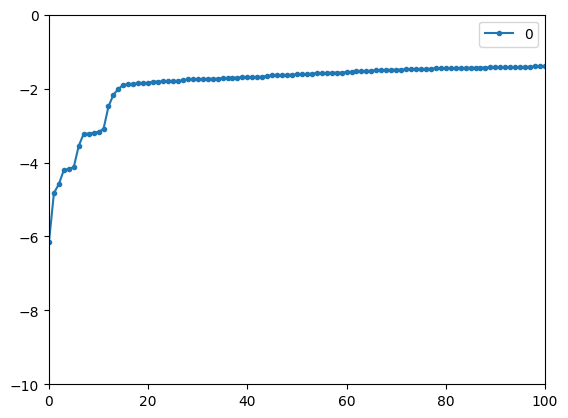

In [433]:
scores = pd.DataFrame(scores)
scores.plot( xlim = [0,100],ylim = [-10,0],style='.-')
plt.show()

In [434]:
scores

,0
0,-6.152075
1,-4.825238
2,-4.584563
3,-4.201625
4,-4.177002
...,...
1532,-0.972607
1533,-0.969055
1534,-0.968953
1535,-0.963351


In [435]:
scores[scores[0]<-2] # then we need to access the indices of these data points

,0
0,-6.152075
1,-4.825238
2,-4.584563
3,-4.201625
4,-4.177002
5,-4.123023
6,-3.549921
7,-3.222296
8,-3.218263
9,-3.199430


#### EDA: Duplicate Detection

In [436]:
# DUPLICATED COLUMNS
duplicated_df = df_merged.T[df_merged.T.duplicated()]
duplicated_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Sensor-150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sensor-535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [437]:
duplicated_df.index

Index(['Sensor-150', 'Sensor-180', 'Sensor-187', 'Sensor-190', 'Sensor-192',
       'Sensor-193', 'Sensor-194', 'Sensor-195', 'Sensor-227', 'Sensor-230',
       ...
       'Sensor-530', 'Sensor-531', 'Sensor-532', 'Sensor-533', 'Sensor-534',
       'Sensor-535', 'Sensor-536', 'Sensor-537', 'Sensor-538', 'Sensor-539'],
      dtype='object', length=104)

In [438]:
df_merged.T[df_merged.T.duplicated()].shape

(104, 1537)

In [439]:
# DUPLICATED ROWS:
df_merged.duplicated().sum()

0

In [440]:
filt = df_merged[col]==0

In [441]:
zero_check = [col  for col in df_merged.columns if (df_merged[col].fillna(0)==0.0).sum()==df_merged.shape[0]]

In [442]:
zero_check

['Sensor-14',
 'Sensor-53',
 'Sensor-98',
 'Sensor-142',
 'Sensor-150',
 'Sensor-179',
 'Sensor-180',
 'Sensor-187',
 'Sensor-190',
 'Sensor-191',
 'Sensor-192',
 'Sensor-193',
 'Sensor-194',
 'Sensor-195',
 'Sensor-227',
 'Sensor-230',
 'Sensor-231',
 'Sensor-232',
 'Sensor-233',
 'Sensor-234',
 'Sensor-235',
 'Sensor-236',
 'Sensor-237',
 'Sensor-238',
 'Sensor-241',
 'Sensor-242',
 'Sensor-243',
 'Sensor-244',
 'Sensor-257',
 'Sensor-258',
 'Sensor-259',
 'Sensor-260',
 'Sensor-261',
 'Sensor-262',
 'Sensor-263',
 'Sensor-264',
 'Sensor-265',
 'Sensor-266',
 'Sensor-267',
 'Sensor-277',
 'Sensor-285',
 'Sensor-314',
 'Sensor-315',
 'Sensor-316',
 'Sensor-323',
 'Sensor-326',
 'Sensor-327',
 'Sensor-328',
 'Sensor-329',
 'Sensor-330',
 'Sensor-331',
 'Sensor-365',
 'Sensor-370',
 'Sensor-371',
 'Sensor-372',
 'Sensor-373',
 'Sensor-374',
 'Sensor-375',
 'Sensor-376',
 'Sensor-379',
 'Sensor-380',
 'Sensor-381',
 'Sensor-382',
 'Sensor-395',
 'Sensor-396',
 'Sensor-397',
 'Sensor-398'

In [443]:
len(zero_check)

112

In [444]:
df_merged["Sensor-538"].value_counts()

Sensor-538
0.0    1528
Name: count, dtype: int64

In [445]:
(df_merged["Sensor-538"].fillna(0)==0.0).sum()==df_merged.shape[0]

True

### EDA: Distribution Analysis

In [446]:
from scipy import stats

In [447]:
dist_types = [stats.norm, stats.expon, stats.gamma, stats.lognorm, stats.pareto]

In [448]:
def get_distribution(dataframe:pd.DataFrame, col_name):
    best_fit = None 
    best_p_value = np.inf 

    for dist in dist_types:
        params = dist.fit(dataframe[col_name].fillna(0.00001))
        _, p_value = stats.kstest(dataframe[col_name].fillna(0.00001), dist.cdf, args=params)
        if p_value < best_p_value:
            best_fit = dist 
            best_p_value = p_value

    print(f"{col_name} -> Best-fit distribution: {best_fit.name}")
    return best_fit.name 

In [449]:
best_fit_list = []
for col in df_merged.columns[:-1]:
    best_fit = get_distribution(df_merged,col)
    best_fit_list.append(best_fit)

Sensor-1 -> Best-fit distribution: expon
Sensor-2 -> Best-fit distribution: expon
Sensor-3 -> Best-fit distribution: expon
Sensor-4 -> Best-fit distribution: lognorm
Sensor-5 -> Best-fit distribution: norm
Sensor-6 -> Best-fit distribution: norm
Sensor-7 -> Best-fit distribution: expon
Sensor-8 -> Best-fit distribution: expon
Sensor-9 -> Best-fit distribution: expon
Sensor-10 -> Best-fit distribution: pareto
Sensor-11 -> Best-fit distribution: pareto
Sensor-12 -> Best-fit distribution: expon
Sensor-13 -> Best-fit distribution: expon
Sensor-14 -> Best-fit distribution: norm
Sensor-15 -> Best-fit distribution: pareto
Sensor-16 -> Best-fit distribution: expon
Sensor-17 -> Best-fit distribution: expon
Sensor-18 -> Best-fit distribution: expon
Sensor-19 -> Best-fit distribution: expon
Sensor-20 -> Best-fit distribution: expon
Sensor-21 -> Best-fit distribution: expon
Sensor-22 -> Best-fit distribution: gamma
Sensor-23 -> Best-fit distribution: expon
Sensor-24 -> Best-fit distribution: logno

In [450]:
best_fits = pd.Series(best_fit_list)

In [451]:
best_fits.value_counts()

norm       153
gamma      148
expon      134
pareto     112
lognorm     43
Name: count, dtype: int64

### EDA: Target Imbalance Check

In [452]:
df_merged["Good/Bad"].value_counts(normalize=True)

Good/Bad
-1    0.942095
 1    0.057905
Name: proportion, dtype: float64

### EDA: Correlation Analysis

In [453]:
corr_matrix =  df_merged.corr(method="pearson")

In [454]:
filt = (abs(corr_matrix)>0.95) & (abs(corr_matrix)<1.00)

In [455]:
threshold = 5
corr_counts = filt.sum(axis=1)

In [456]:
corr_counts[corr_counts>2].sort_values(ascending=False)

Sensor-245    9
Sensor-383    9
Sensor-519    9
Sensor-422    9
Sensor-517    9
Sensor-246    8
Sensor-247    8
Sensor-385    8
Sensor-384    8
Sensor-518    8
Sensor-284    7
Sensor-149    7
Sensor-153    6
Sensor-288    6
Sensor-173    5
Sensor-426    5
Sensor-348    5
Sensor-310    5
Sensor-308    5
Sensor-428    5
Sensor-175    5
Sensor-444    5
Sensor-446    5
Sensor-17     5
Sensor-207    4
Sensor-110    4
Sensor-391    3
Sensor-300    3
Sensor-343    3
Sensor-301    3
Sensor-75     3
Sensor-290    3
Sensor-253    3
Sensor-166    3
Sensor-165    3
Sensor-155    3
Sensor-118    3
Sensor-525    3
dtype: int64

In [457]:
df_merged.columns[corr_counts>threshold]

Index(['Sensor-149', 'Sensor-153', 'Sensor-245', 'Sensor-246', 'Sensor-247',
       'Sensor-284', 'Sensor-288', 'Sensor-383', 'Sensor-384', 'Sensor-385',
       'Sensor-422', 'Sensor-517', 'Sensor-518', 'Sensor-519'],
      dtype='object')

****

****

## DATA TRANSFORMATION & FEATURE ENGINEERING

### NOTES (COPY)
- all meaningful input features are float64 dtype
- wafer id can be removed
- raw data is highly unscaled
- lots of outliers, even when i set iqr_threshold to 5% and coefficient to 5, there were still lots of outliers
- as an alternative, i peformed multivariate outlier detection using LOF, the elbow method suggested the threshold score to be <-2
- there is no duplicated rows, but are a lot of (more than 100) duplicated columns, may be these are all zero columns.
- there are 112 columns of constant value "0" 
- best_fit_distribution types are found , re-assess after data transformation
- highly imbalanced dataset, handle imbalance with stratified kfold when splitting as train-test dataset
- correlation study is performed with filter condition of abs(corr)>95 or abs(cor)<100 and if the correlated column count > threshold=5  , some columns meeting these conditions are detected

# DATA TRANFORMATION TASK LIST
##### (!) turn all the work into modular functions / classes

[x] - handle unwanted data

[x] - drop zero std columns

[x] - drop highly correlated columns

[x] - drop duplicated columns/rows

[x]  - handle missing values

[x] - handle outliers

[] - scale the dataframe

     - provide different scaling options
     
     - check distributions afterwards



In [9]:
df_merged.columns

Index(['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-6',
       'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=591)

In [10]:
df_merged.shape 

(1537, 591)

#### -> DATA TRANSFORMATION: ZERO STD CHECK

In [11]:
zero_check = [col  for col in df_merged.columns if (df_merged[col].fillna(0)==0.0).sum()==df_merged.shape[0]]

In [12]:
len(zero_check)

112

In [20]:
(df_merged.std() == 0 ).sum() # 112 of them are all zero columns

116

In [22]:
def drop_zero_std(dataframe:pd.DataFrame)->pd.DataFrame:
    zero_std_cols = dataframe.columns[dataframe.std()==0]
    dataframe2 = dataframe.drop(columns=zero_std_cols)
    return dataframe2

In [29]:
df_zero_std_dropped = drop_zero_std(df_merged)

****

#### -> DATA TRANSFORMATION: Drop highly correlated columns

In [ ]:
corr_matrix = df.corr(method="pearson")
filt = (abs(corr_matrix)>0.95) & (abs(corr_matrix)<1.00) # threshold 95% 
threshold = 5
corr_counts = filt.sum(axis=1)
corr_counts[corr_counts>2].sort_values(ascending=False)

In [33]:
def drop_highly_correlated_columns(dataframe:pd.DataFrame,corr_threshold=0.95,count_threshold=3):

    corr_matrix= dataframe.corr(method="pearson")
    filt = (abs(corr_matrix)>corr_threshold) & (abs(corr_matrix)<1.00)
    corr_counts = filt.sum(axis=1)
    #highly_correlated = corr_counts[cor_counts > count_threshold].sort_values(ascending=False)
    highly_correlated_cols = dataframe.columns[corr_counts>count_threshold]

    return dataframe.drop(columns=highly_correlated_cols)

In [37]:
df_no_corr = drop_highly_correlated_columns(dataframe=df_merged,count_threshold=5)

In [38]:
df_no_corr.shape 

(1537, 577)

****

#### -> DATA TRANSFORMATION: Drop duplicated columns

In [53]:
df_merged.T[df_merged.T.duplicated()].index

Index(['Sensor-150', 'Sensor-180', 'Sensor-187', 'Sensor-190', 'Sensor-192',
       'Sensor-193', 'Sensor-194', 'Sensor-195', 'Sensor-227', 'Sensor-230',
       ...
       'Sensor-530', 'Sensor-531', 'Sensor-532', 'Sensor-533', 'Sensor-534',
       'Sensor-535', 'Sensor-536', 'Sensor-537', 'Sensor-538', 'Sensor-539'],
      dtype='object', length=104)

In [54]:
def drop_duplicated_cols(dataframe:pd.DataFrame)->pd.DataFrame:
    duplicated_cols = dataframe.T[dataframe.T.duplicated()].index
    return dataframe.drop(columns=duplicated_cols)

****

#### -> DATA TRANSFORMATION: Handle Missing Values

In [58]:
def missing_values_table(dataframe:pd.DataFrame,is_return= False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isna().sum()>0]
    na_data = dataframe[na_cols].isna().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.concat(objs=[na_data,np.round(ratio,2)],axis=1,keys= ["#missing","ratio"])
    print(missing_df,end="\n")
    if is_return:
        return (na_cols,missing_df)
    return missing_df

In [59]:
def missing_vs_target(dataframe:pd.DataFrame,target:str,na_cols:list):
    i=0
    temp_df = dataframe.copy()
    for col in na_cols:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isna(),1,0)
    
    na_flags= [col for col in temp_df.columns if "_NA_FLAG" in col ]
    

    
    for col in na_flags:
        table= pd.DataFrame({
            "Target_Mean": temp_df.groupby(col)[target].mean(),
            "count":temp_df.groupby(col)[target].count()
        })

        if (abs(table.iloc[1,0])> 0.30) and  (abs(table.iloc[1,0])< 0.70) :
            i+=1
            print(table,end="\n\n")

In [60]:
def missing_row_analysis(dataframe:pd.DataFrame):
    table= pd.DataFrame({
        "#missing":dataframe.isna().sum(axis=1).sort_values(ascending=False),
        "ratio": dataframe.isna().sum(axis=1).sort_values(ascending=False)/ dataframe.shape[0]*100
    })
    return table 


In [133]:
from sklearn.impute import KNNImputer

In [159]:
class HandleMissingValues:
    def __init__(self,dataframe:pd.DataFrame):
        self.dataframe = dataframe


    def missing_values_table(self,is_return= True):

        """
        Generate a summary of missing values in the DataFrame.

        Parameters:
        - is_return (bool)

        Returns:
        - If is_return is True, returns a tuple containing a list of columns with missing values and a DataFrame summarizing the missing values.
        - If is_return is False, returns a DataFrame summarizing the missing values.
        """

        na_cols = [col for col in self.dataframe.columns if self.dataframe[col].isna().sum()>0]
        na_data = self.dataframe[na_cols].isna().sum().sort_values(ascending=False)
        ratio = (self.dataframe[na_cols].isna().sum()/self.dataframe.shape[0]*100).sort_values(ascending=False)
        missing_df = pd.concat(objs=[na_data,np.round(ratio,2)],axis=1,keys= ["#missing","ratio"])
        print(missing_df,end="\n")
        if is_return:
            return (na_cols,missing_df)
        else:
            return missing_df


    def missing_vs_target(self,target:str,na_cols:list, threshold=0.8):
        """
        Check if missing value rows correlate with a specified target variable.

        Parameters:
        - target (str): The name of the target variable for correlation analysis.
        - na_cols (list): A list of columns with missing values.
        - threshold (float): The correlation threshold. Columns with correlations greater than this threshold are considered key columns.

        Returns:
        - key_cols (list): A list of column names that show strong correlation with the target variable.
        """

        key_cols = []
        temp_df = self.dataframe.copy()
        for col in na_cols:
            temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isna(),1,0)
        
        na_flags= [col for col in temp_df.columns if "_NA_FLAG" in col ]
        #print(na_flags)
        for col in na_flags:
            table= pd.DataFrame({
                "Target_Mean": temp_df.groupby(col)[target].mean(),
                "count":temp_df.groupby(col)[target].count()
            })
            #print(table,end="\n\n")

            if (abs(table.iloc[1,0])> threshold) :
                key_cols.append(col.replace("_NA_FLAG",""))
                print(table,end="\n\n")
        return key_cols



    def detect_highly_missing(self,missing_table, ratio_threshold=80):

        """
        Detect columns with a high ratio of missing values.

        Parameters:
        - missing_table (pd.DataFrame): A DataFrame containing missing values information.
        - ratio_threshold (float): The threshold for considering a column as highly missing.

        Returns:
        - highly_missing_cols (list): A list of column names with a high ratio of missing values.
        """

        highly_missing_cols = missing_table.query(f"ratio > {ratio_threshold}").index 

        return highly_missing_cols
        

    def constant_value_imputation(self,constant=0):

        """
        Perform constant value imputation for missing values.

        Parameters:
        - constant: The constant value to use for imputing missing values : can be mean, median, mode or any constant scalar

        Returns:
        - imputed_df (pd.DataFrame): The DataFrame with missing values replaced by the constant value.
        """
        return self.dataframe.fillna(constant)      

    def knn_imputation(self,n_neighbors=10):

        """
        Perform K-Nearest Neighbors (KNN) imputation for missing values.

        Parameters:
        - n_neighbors (int): The number of nearest neighbors to consider during imputation.

        Returns:
        - imputed_df (pd.DataFrame): The DataFrame with missing values imputed using KNN imputation.
        """
        
        knn= KNNImputer(n_neighbors=n_neighbors)
        return pd.DataFrame(knn.fit_transform(self.dataframe),columns=self.dataframe.columns)

    


In [160]:
handle_missing = HandleMissingValues(dataframe=df_zero_std_dropped)

In [137]:
na_cols , missing_table =  handle_missing.missing_values_table()

            #missing  ratio
Sensor-158      1399  91.02
Sensor-294      1399  91.02
Sensor-293      1399  91.02
Sensor-159      1399  91.02
Sensor-221      1311  85.30
...              ...    ...
Sensor-182         1   0.07
Sensor-181         1   0.07
Sensor-178         1   0.07
Sensor-84          1   0.07
Sensor-586         1   0.07

[418 rows x 2 columns]


In [138]:
highly_missing_cols = handle_missing.detect_highly_missing(missing_table,ratio_threshold=80)

In [139]:
key_cols = handle_missing.missing_vs_target(target="Good/Bad",na_cols=highly_missing_cols)

                    Target_Mean  count
Sensor-158_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-294_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-293_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-159_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-221_NA_FLAG                    
0                     -0.902655    226
1                     -0.881007   1311

                    Target_Mean  count
Sensor-359_NA_FLAG                    
0                     -0.902655    226
1                     -0.881007   1311

                    Target_Mean  count
Sensor-493_NA_FLAG 

In [140]:
key_cols

['Sensor-158',
 'Sensor-294',
 'Sensor-293',
 'Sensor-159',
 'Sensor-221',
 'Sensor-359',
 'Sensor-493',
 'Sensor-86']

In [163]:
handle_missing.knn_imputation().isna().sum().sum()

0

#### -> DATA TRANSFORMATION: Handle Outliers

In [291]:
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt 

In [344]:
class HandleOutliers:
    def __init__(self,dataframe:pd.DataFrame):
        self.dataframe = dataframe 
    

    
    def iqr_threshold(self,col_name:str,threshold,coeff):
        q1= self.dataframe[col_name].quantile(threshold)
        q3 = self.dataframe[col_name].quantile(1-threshold)
        iqr = q3-q1 
        upper = q3 + coeff*iqr 
        lower = q1 - coeff*iqr
        return lower,upper 

    def detect_outliers(self,col_name,index=True,threshold:float=0.05,coeff=1.5):
        lower,upper = self.iqr_threshold(col_name,threshold,coeff)
        filt = (self.dataframe[col_name] > upper) | (self.dataframe[col_name] < lower)
        if index:
            return (self.dataframe[filt].index, self.dataframe.loc[self.dataframe[filt].index,col_name])
        else: 
            return self.dataframe[filt]
            



    def iqr_approach(self,col_list,threshold:float= 0.05,coeff=3):
        indices = []
        values = []
        for col in col_list:
            index_list , value_list = self.detect_outliers(col,threshold=threshold, coeff=coeff)
            if len(index_list)>0:
                indices.append((col,index_list))
        return indices

    
    def find_critical_lof(self, n_neighbors=10, contamination=0.1, threshold=0.01):

        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        y_pred = lof.fit_predict(self.dataframe)
        scores= lof.negative_outlier_factor_
        sorted_scores = sorted(scores)

        critical_lof = None

        abs_diff_scores = np.abs(np.diff(sorted_scores))
        percentage = (abs_diff_scores/sorted_scores[:-1])

        critical_index = np.argmax(abs_diff_scores < threshold)
        
        if critical_index > 0: 
            critical_lof = sorted_scores[critical_index]
        
        else:
            critical_lof = None



        # Plot the LOF scores for the specified range of n_neighbors
        plt.plot(range(len(scores)),sorted_scores,marker = 'o', linestyle='-')
        plt.xlabel('data')
        plt.ylabel('LOF Scores')
        plt.title('LOF Score vs. data')
        plt.grid(True)
        plt.show()

        return (critical_lof,pd.DataFrame(scores))


    def multivariate_w_lof(self,n_neighbors=20,contamination=0.1):
        # This should be applied to datasets with no missing values

        lof = LocalOutlierFactor(n_neighbors=10)
        y_pred = lof.fit_predict(self.dataframe)
        scores= sorted(lof.negative_outlier_factor_)
        scores = pd.DataFrame(scores)
        scores.plot( xlim = [0,100],ylim = [-10,0],style='.-')
        plt.show()
        return scores

    def drop_outliers(self,col,row_list):
        temp_df = self.dataframe.copy()
        for row in row_list:
            temp_df.at[row,col] = float("nan")

        return temp_df
    
    def impute_outliers(self,value):
        pass 
    



In [345]:
handle_outliers = HandleOutliers(df_zero_std_dropped.fillna(0))

In [319]:
ind = handle_outliers.iqr_approach(df_zero_std_dropped.columns[:-1])

In [320]:
ind 

[('Sensor-1', Index([8, 95, 55, 2, 36, 87], dtype='int64')),
 ('Sensor-2', Index([80, 54, 1, 73, 72, 88, 92], dtype='int64')),
 ('Sensor-3',
  Index([18, 65, 90, 93, 98, 18, 20, 29, 30, 31, 37, 39, 1, 10], dtype='int64')),
 ('Sensor-7',
  Index([18, 65, 90, 93, 98, 18, 20, 29, 30, 31, 37, 39, 1, 10], dtype='int64')),
 ('Sensor-9', Index([34, 36], dtype='int64')),
 ('Sensor-12',
  Index([67, 67, 67, 67, 34, 36, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67, 67], dtype='int64')),
 ('Sensor-13',
  Index([9, 9, 9, 9, 9, 34, 36, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], dtype='int64')),
 ('Sensor-16',
  Index([31, 99, 31, 99, 31, 99, 31, 99, 31, 34, 36, 31, 99, 31, 99, 31, 99, 31,
         99, 31, 99, 31, 99, 31, 99, 31, 99, 31, 99, 31, 99, 31, 99],
        dtype='int64')),
 ('Sensor-17',
  Index([ 9, 93,  9, 93,  9, 93,  9, 93,  9, 31, 34, 36,  9, 93,  9, 93,  9, 93,
          9, 93,  9, 93,  9, 93,  9, 93,  9, 93,  9, 93,  9, 93,  9, 93],
        dtype='int64')),
 ('Sensor-18',
  Index([67, 67, 67, 67, 

In [284]:
counter = 0

for col,ind_list in ind:
    counter += len(ind_list)

counter 

748

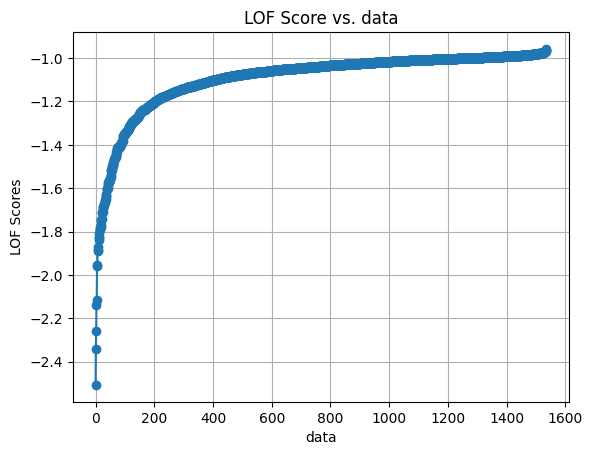

In [346]:
elbow_point,scores = handle_outliers.find_critical_lof(threshold=0.01)

In [347]:
elbow_point

-1.960677139438412

In [348]:
scores 

,0
0,-1.027133
1,-0.970251
2,-1.016142
3,-1.015488
4,-1.145673
...,...
1532,-1.223366
1533,-0.992832
1534,-1.035388
1535,-1.007017


In [355]:
scores[scores[0]<elbow_point]

,0
137,-2.260706
337,-2.139177
935,-2.117580
1187,-2.507885
1299,-2.340123


****

#### -> DATA TRANSFORMATION: Handle Scaling

In [364]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler, RobustScaler

In [372]:
class HandleScaling:
    def __init__(self,dataframe:pd.DataFrame):
        self.dataframe = dataframe

    def standard_scaler(self):
        ss = StandardScaler()
        return pd.DataFrame(ss.fit_transform(self.dataframe),columns=self.dataframe.columns)
    
    def robust_scaler(self):
        rs = RobustScaler()
        return pd.DataFrame(rs.fit_transform(self.dataframe),columns=self.dataframe.columns)


    def min_max_scaler(self,feature_range=(0,1)):
        mms = MinMaxScaler(feature_range=feature_range)
        return pd.DataFrame(mms.fit_transform(self.dataframe),columns=self.dataframe.columns)



In [378]:
handle_scaling= HandleScaling(y[["Sensor-1"]])

In [379]:
handle_scaling.min_max_scaler().describe()

,Sensor-1
count,1537.000000
mean,0.894798
std,0.060190
min,0.000000
25%,0.883776
50%,0.897350
75%,0.910903
max,1.000000


In [380]:
handle_scaling.robust_scaler().describe()

,Sensor-1
count,1537.000000
mean,-0.094076
std,2.218774
min,-33.078748
25%,-0.500384
50%,0.000000
75%,0.499616
max,3.783965


In [381]:
handle_scaling.standard_scaler().describe()

,Sensor-1
count,1.537000e+03
mean,-1.118747e-15
std,1.000325e+00
min,-1.487101e+01
25%,-1.831828e-01
50%,4.241361e-02
75%,2.676634e-01
max,1.748399e+00


(array([  6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   3.,  12.,  27.,  83., 158.,
        257., 297., 281., 223., 100.,  18.,  25.,  26.,  11.,   5.,   1.,
          2.]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
        0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
        0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
        0.44, 0.45, 0.

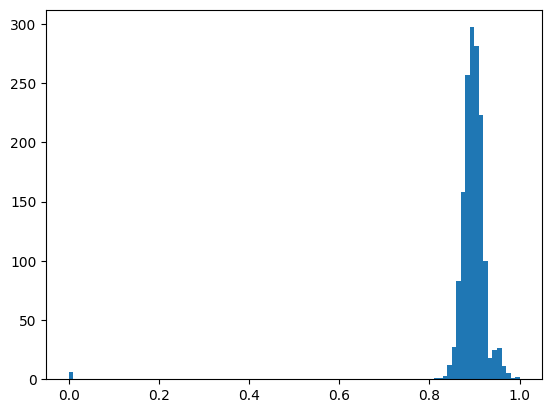

In [387]:
scaled_df = handle_scaling.min_max_scaler()
plt.hist(scaled_df,bins=100 )

(array([  6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   3.,  12.,  27.,  83., 158.,
        257., 297., 281., 223., 100.,  18.,  25.,  26.,  11.,   5.,   1.,
          2.]),
 array([-33.07874794, -32.71012081, -32.34149368, -31.97286656,
        -31.60423943, -31.2356123 , -30.86698517, -30.49835805,
        -30.12973092, -29.76110379, -29.39247666, -29.02384953,
        -28.65522241, -28.28659528, -27.91796815, -27.54934102,
        -27.18071389, -26.81208677, -26.44345964, -26.07483251

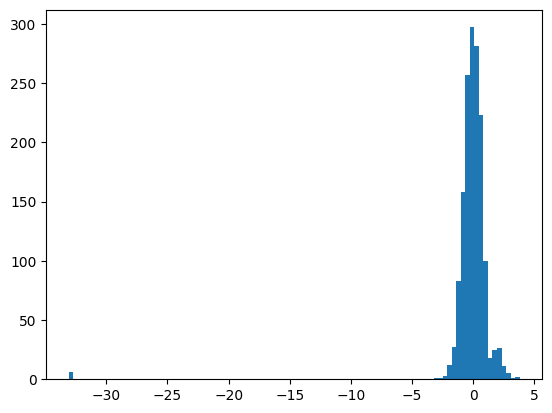

In [388]:
scaled_df = handle_scaling.robust_scaler()
plt.hist(scaled_df,bins=100 )

(array([  6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   3.,  12.,  27.,  83., 158.,
        257., 297., 281., 223., 100.,  18.,  25.,  26.,  11.,   5.,   1.,
          2.]),
 array([-14.8710115 , -14.70481739, -14.53862328, -14.37242917,
        -14.20623506, -14.04004095, -13.87384684, -13.70765273,
        -13.54145862, -13.37526451, -13.2090704 , -13.04287629,
        -12.87668218, -12.71048807, -12.54429396, -12.37809985,
        -12.21190574, -12.04571163, -11.87951752, -11.71332341

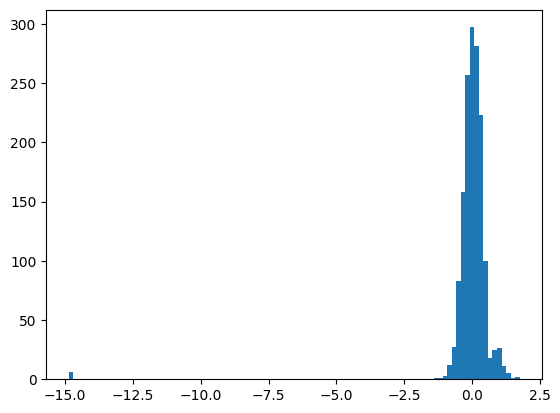

In [389]:
scaled_df = handle_scaling.standard_scaler()
plt.hist(scaled_df,bins=100 )